In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [17]:
from medvqa.utils.files import load_pickle
from medvqa.evaluation.plots import plot_metrics, visualize_image_and_polygons
import numpy as np
import medvqa
import os
from importlib import reload

In [123]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

# 1) Phrase Grounding: DenseNet121 + CXRFE + Sigmoid-based attention

In [9]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_feature_extra

In [11]:
tmp1 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/vindrcxr_metrics.pkl')

In [129]:
tmp = tmp1

In [130]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'segmask_iou', 'prc_auc'])

posx and posy should be finite values


posx and posy should be finite values


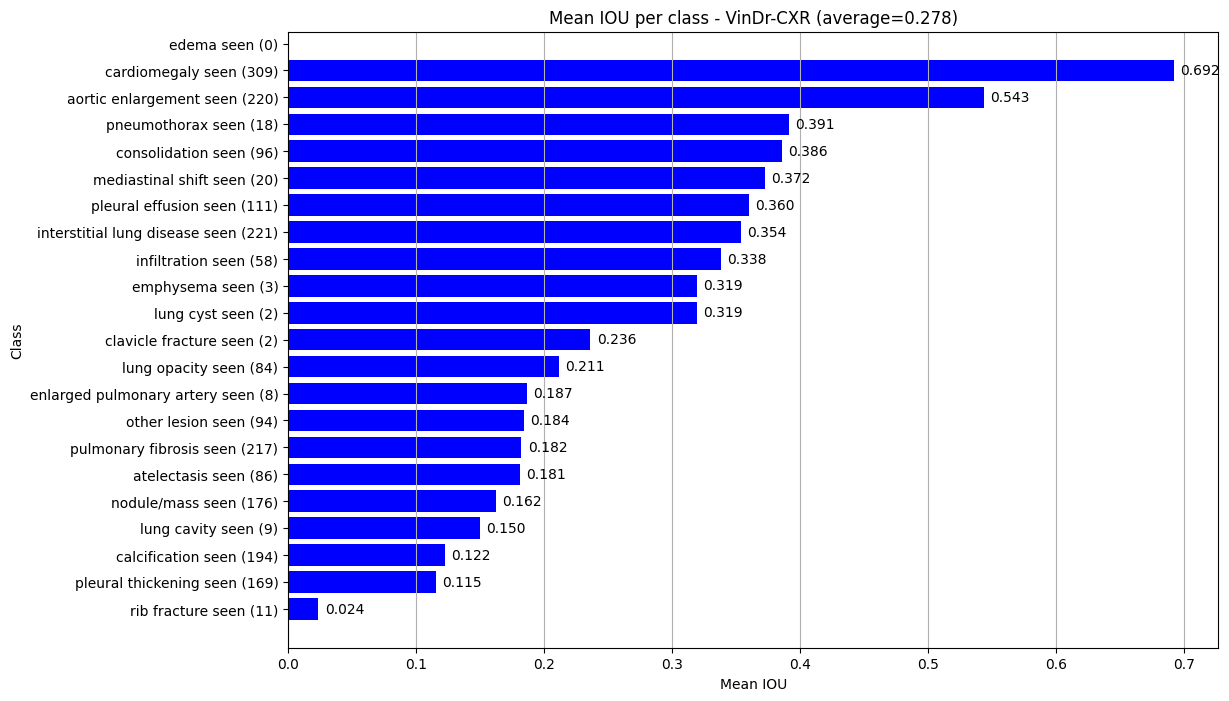

In [131]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [19]:
from medvqa.evaluation.plots import visualize_attention_maps

In [49]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [77]:
# idx = idxs[-200]
idx = idxs[200]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0.7070717811584473

/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/889347926c284c6c61234b357153d327.jpg

interstitial lung disease seen


In [26]:
from medvqa.datasets.vinbig import load_test_image_id_2_bboxes, visualize_image_with_bounding_boxes
test_image_id_2_bboxes = load_test_image_id_2_bboxes()

Anomalous bboxes found: 0 of 2697


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/889347926c284c6c61234b357153d327.jpg
0: ILD
[[335.2509977817093, 551.816172253801, 788.6113235322391, 1605.0496119547272], [1269.6155715846303, 485.4707587293333, 1753.3842118672085, 1563.5837285019347]]


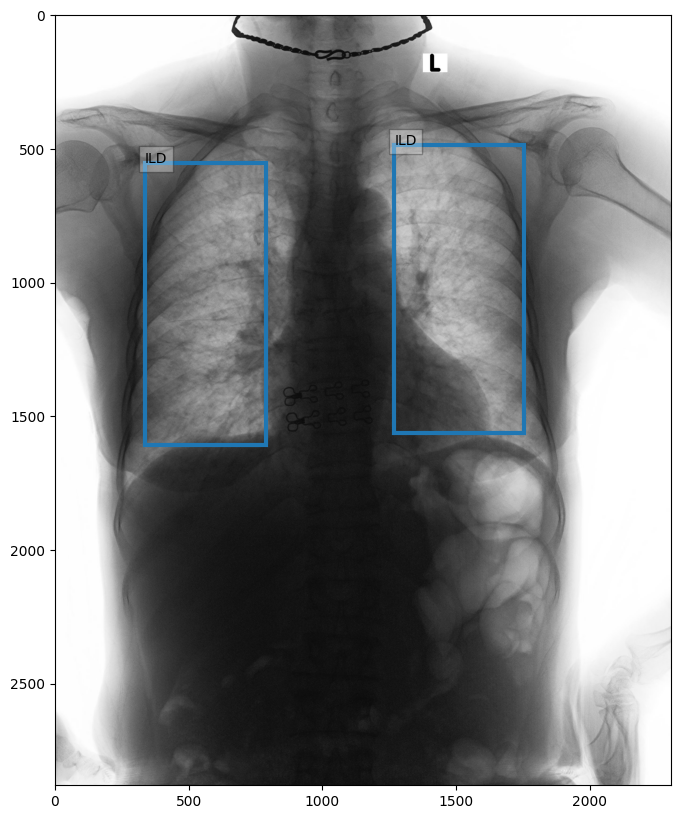

In [78]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

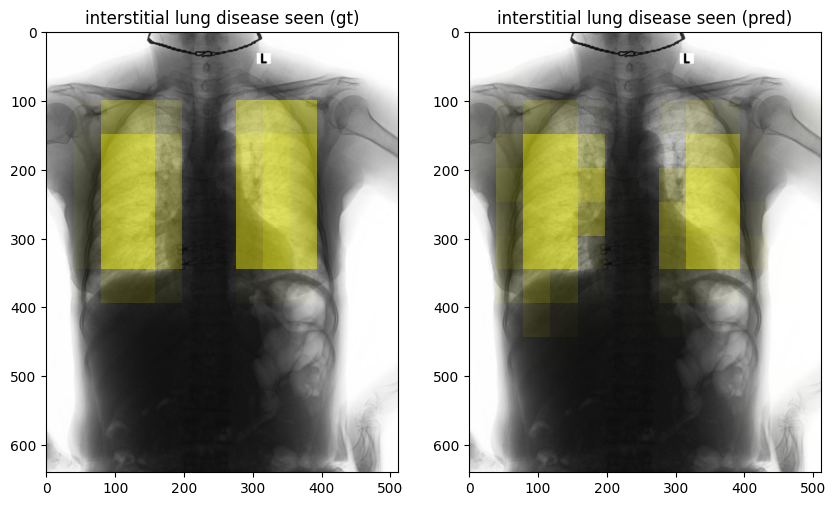

In [79]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

# 2) Phrase Grounding: DenseNet121 + CXRFE + Transformer Encoder

In [80]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_featu

# 3) Phrase Grounding: DenseNet121 + CXRFE + FiLM-based attention

In [81]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-12

In [82]:
tmp3 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)/vindrcxr_metrics.pkl')

In [126]:
tmp = tmp3

In [127]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'segmask_iou', 'prc_auc'])

posx and posy should be finite values


posx and posy should be finite values


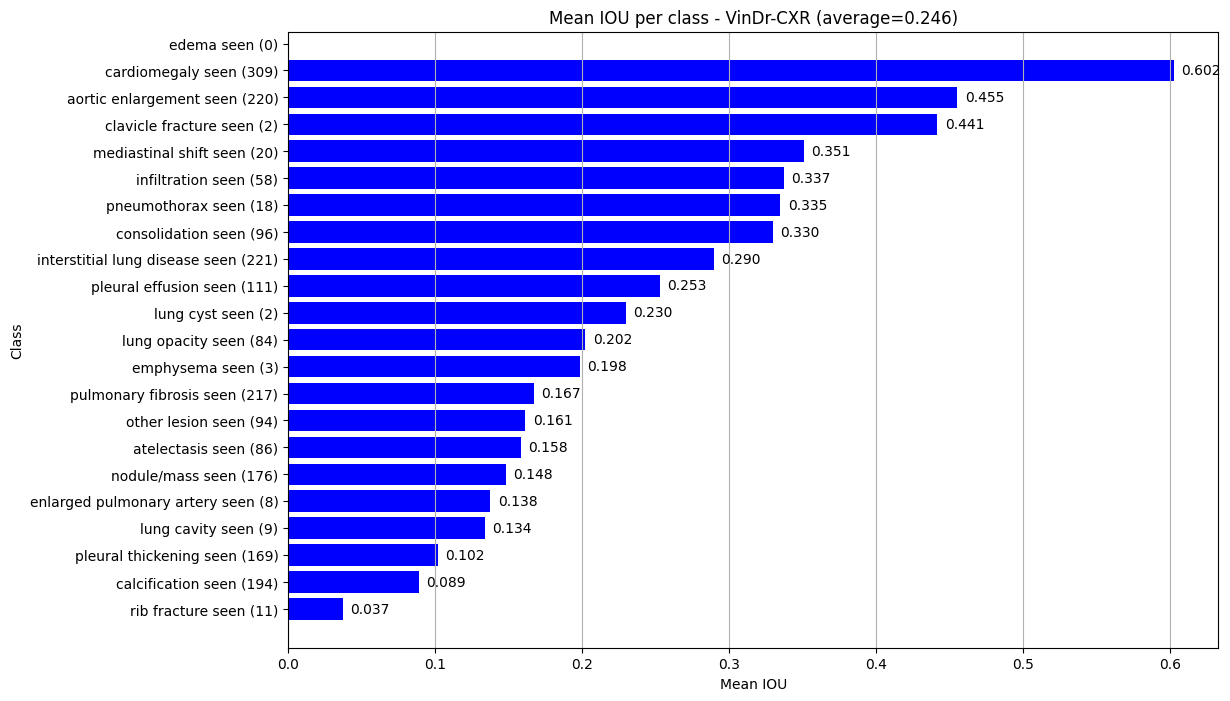

In [128]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [87]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [116]:
# idx = idxs[-200]
idx = idxs[-500]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0.06893625110387802

/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/b856f3db2491d631aa4300206b97ff82.jpg

pulmonary fibrosis seen


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/b856f3db2491d631aa4300206b97ff82.jpg
0: ILD
[[456.8576358404049, 1316.1147173953464, 1046.6127684311336, 1896.35767042816]]
1: Nodule/Mass
[[725.2047387729664, 1460.8034860750136, 1043.8627539631182, 1734.278648365069]]
2: Pleural effusion
[[335.5773464769885, 1630.0166428065406, 689.9060350093217, 1939.1624784387773]]
3: Pleural thickening
[[2085.442266866496, 1979.2380226523337, 2181.980020369589, 2239.889957110689]]
4: Pulmonary fibrosis
[[418.8089176087447, 1194.8344280319302, 789.7839203674289, 1356.541480516485]]


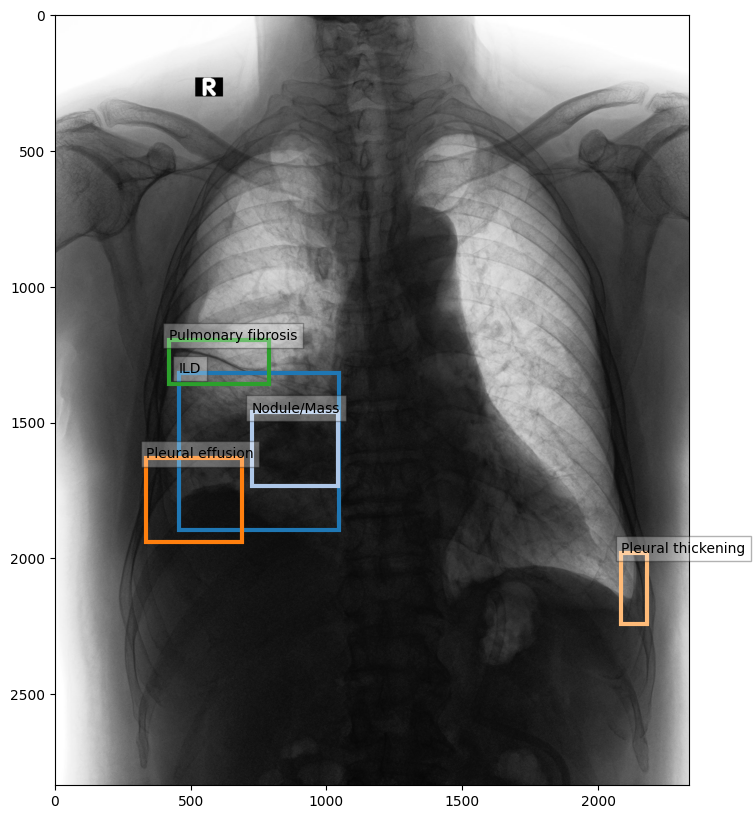

In [117]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

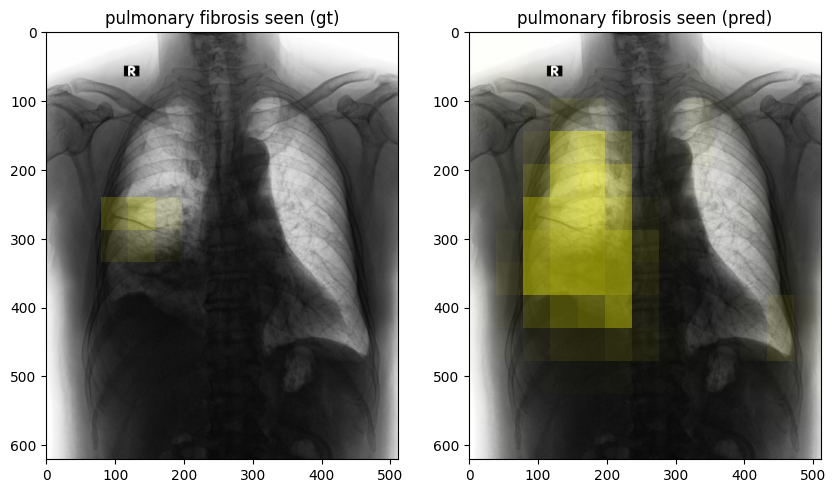

In [118]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

In [90]:
from medvqa.datasets.vinbig import load_train_image_id_2_bboxes

In [91]:
train_image_id_2_bboxes = load_train_image_id_2_bboxes()

Anomalous bboxes found: 0 of 37367


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/0007d316f756b3fa0baea2ff514ce945.jpg
0: Aortic enlargement
[[1275.2900390625, 1039.9000244141, 1498.7099609375, 1241.6199951172], [1235.9799804688, 1021.6400146484, 1482.9000244141, 1281.9799804688]]
1: Cardiomegaly
[[902.03997802734, 1827.7399902344, 1829.6700439453, 2037.0200195312]]
2: ILD
[[1847.3100585938, 1409.9899902344, 2093.1201171875, 2096.5500488281], [535.40399169922, 1748.9799804688, 932.21997070312, 2013.0600585938]]
3: Pleural thickening
[[818.666015625, 677.09802246094, 987.66998291016, 939.34497070312], [621.36499023438, 673.40600585938, 1025.8599853516, 851.7340087890599], [790.0479736328099, 634.90301513672, 1047.8399658203, 725.0390014648401]]
4: Pulmonary fibrosis
[[818.666015625, 677.09802246094, 987.66998291016, 939.34497070312], [804.0040283203099, 716.57000732422, 857.5239868164099, 920.35797119141], [1392.7199707031, 702.15997314453, 1518.2900390625, 790.67401123047]]


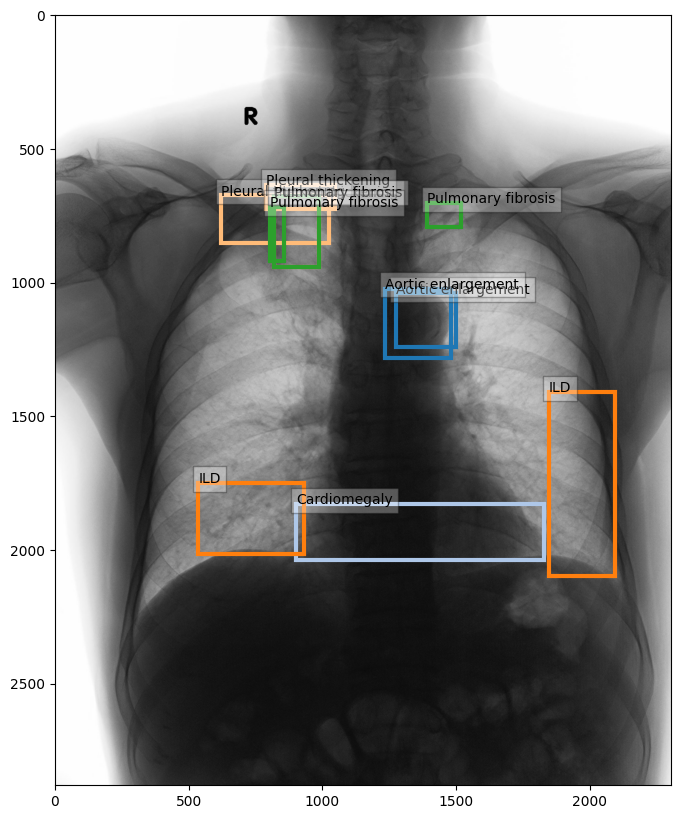

In [11]:
key = os.path.basename('/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/0007d316f756b3fa0baea2ff514ce945.jpg')[:-4]
visualize_image_with_bounding_boxes(key, train_image_id_2_bboxes[key], verbose=True)

# 4) Phrase Grounding: DN121+CXRFE+FiLM+bbox (VinDR-CXR)

In [75]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPu

In [109]:
tmp = load_pickle("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

In [110]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_bboxes', 'gt_bboxes', 'ious', 'bbox_iou', 'prc_auc'])

/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values


posx and posy should be finite values


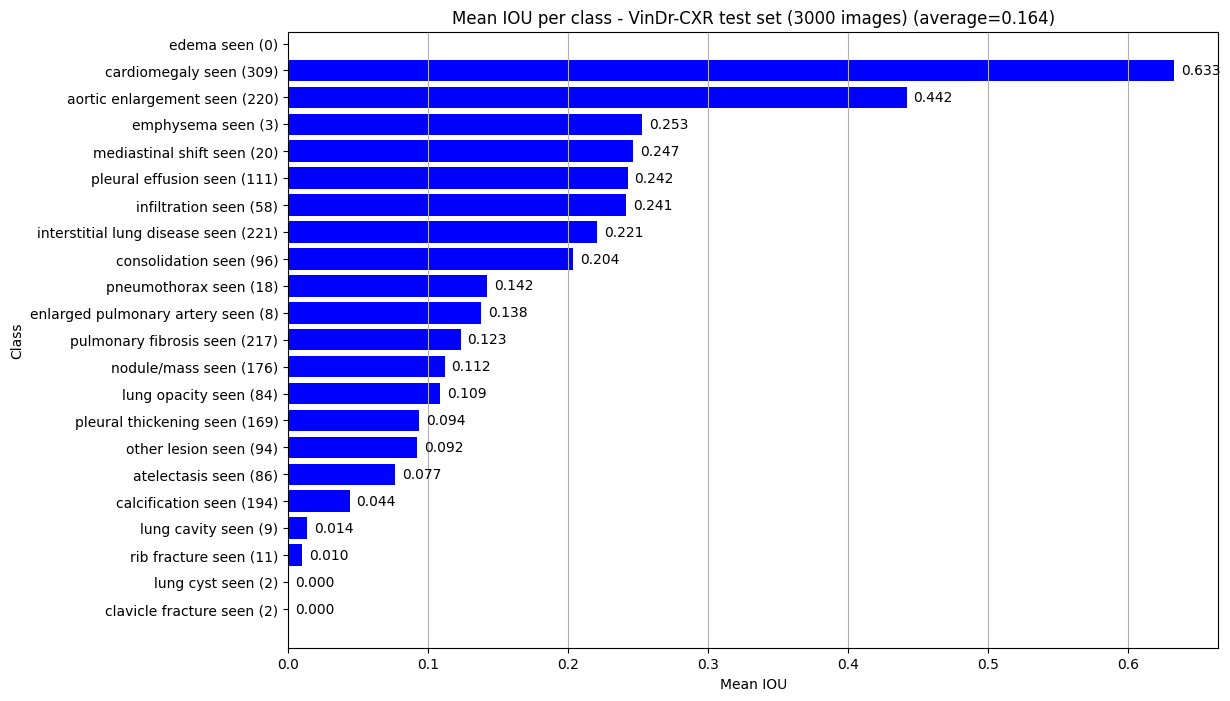

In [117]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [68]:
reload(medvqa.datasets.vinbig)

<module 'medvqa.datasets.vinbig' from '/home/pamessina/medvqa/medvqa/datasets/vinbig/__init__.py'>

In [69]:
from medvqa.datasets.vinbig import compute_label_frequencies

In [70]:
label_frequencies = compute_label_frequencies()

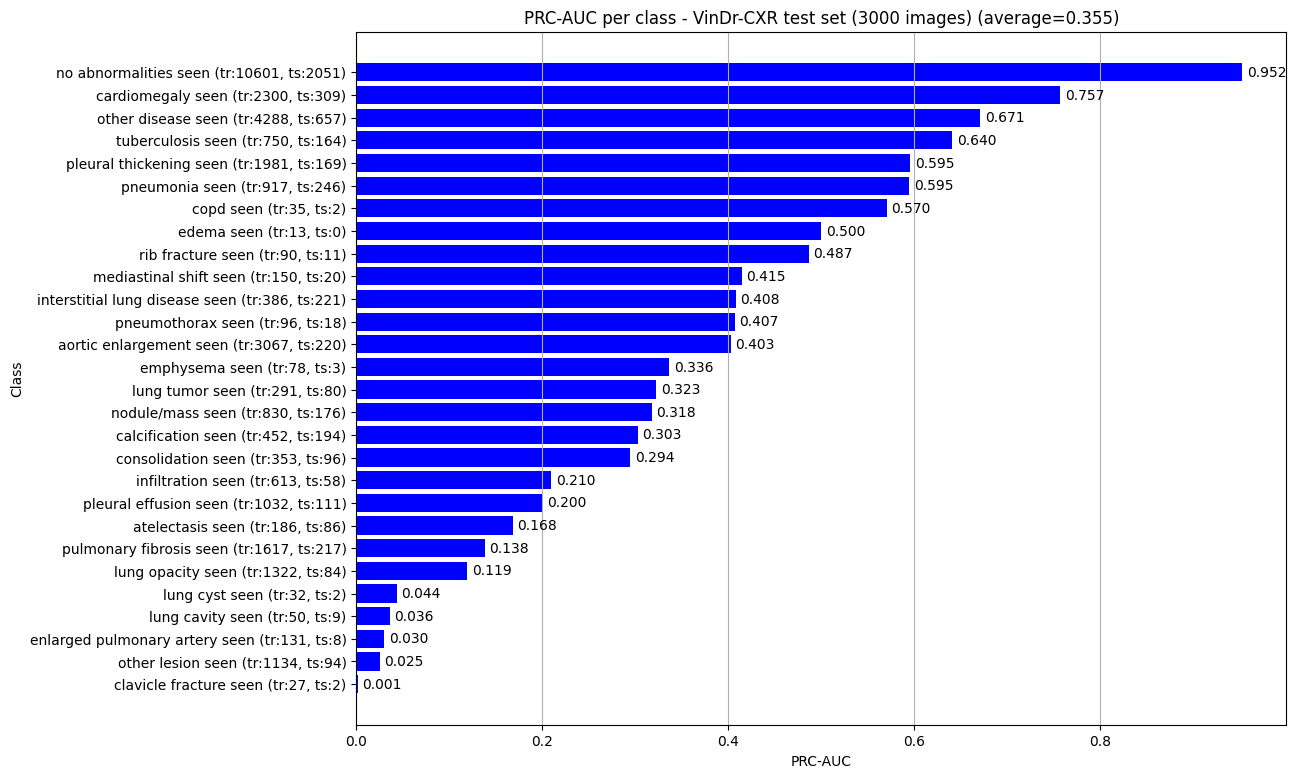

In [118]:
from medvqa.utils.constants import VINBIG_LABELS, VINBIG_LABEL2PHRASE

plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_LABELS],
    metric_values=tmp['prc_auc']['per_class'],
    title='PRC-AUC per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)

In [119]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [133]:
idx = idxs[-10]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0

/mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/c28e30456f3d1b1dda8a22f958b7aa96.jpg

consolidation seen


image_path: /mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images/c28e30456f3d1b1dda8a22f958b7aa96.jpg
0: Consolidation
[[1234.2674134950737, 1197.0789112898806, 1561.2234809904303, 1504.8022689325694]]


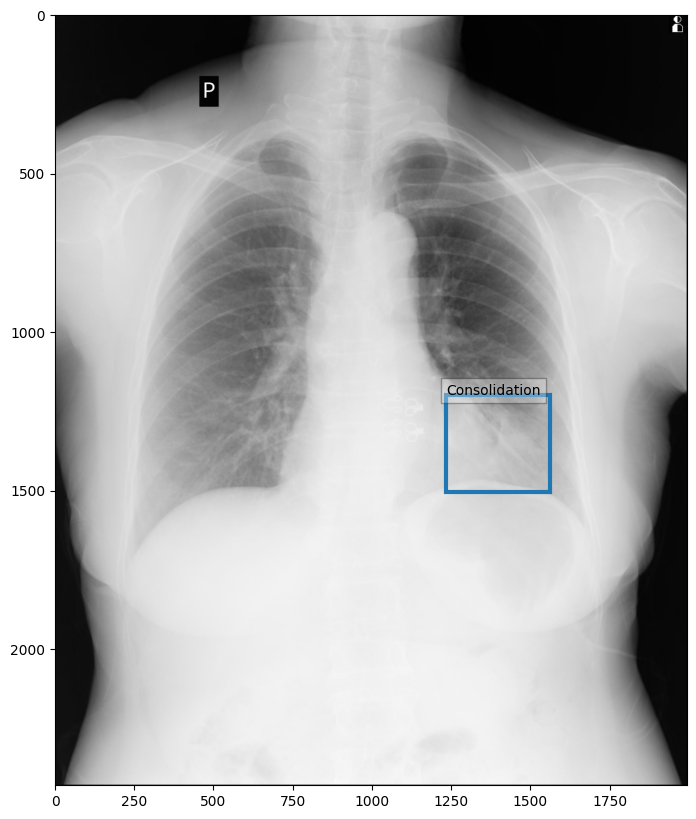

In [134]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

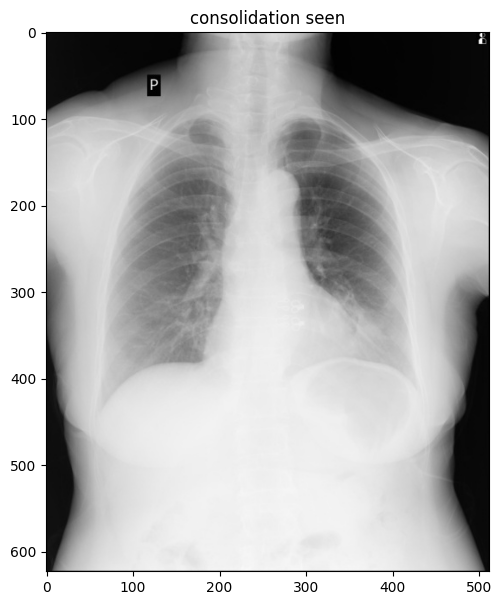

In [135]:
from medvqa.evaluation.plots import visualize_visual_grounding_as_bboxes
visualize_visual_grounding_as_bboxes(
    image_path=tmp['image_paths'][idx],
    phrases=[tmp['phrases'][idx]],
    bboxes=[tmp['pred_bboxes'][idx]] if tmp['pred_bboxes'][idx] is not None else [[]],
    figsize=(7, 7),
    max_cols=1,
)

In [74]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig \
--vinbig_use_training_indices_for_validation

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPur

In [76]:
tmp2 = load_pickle("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression).pkl")

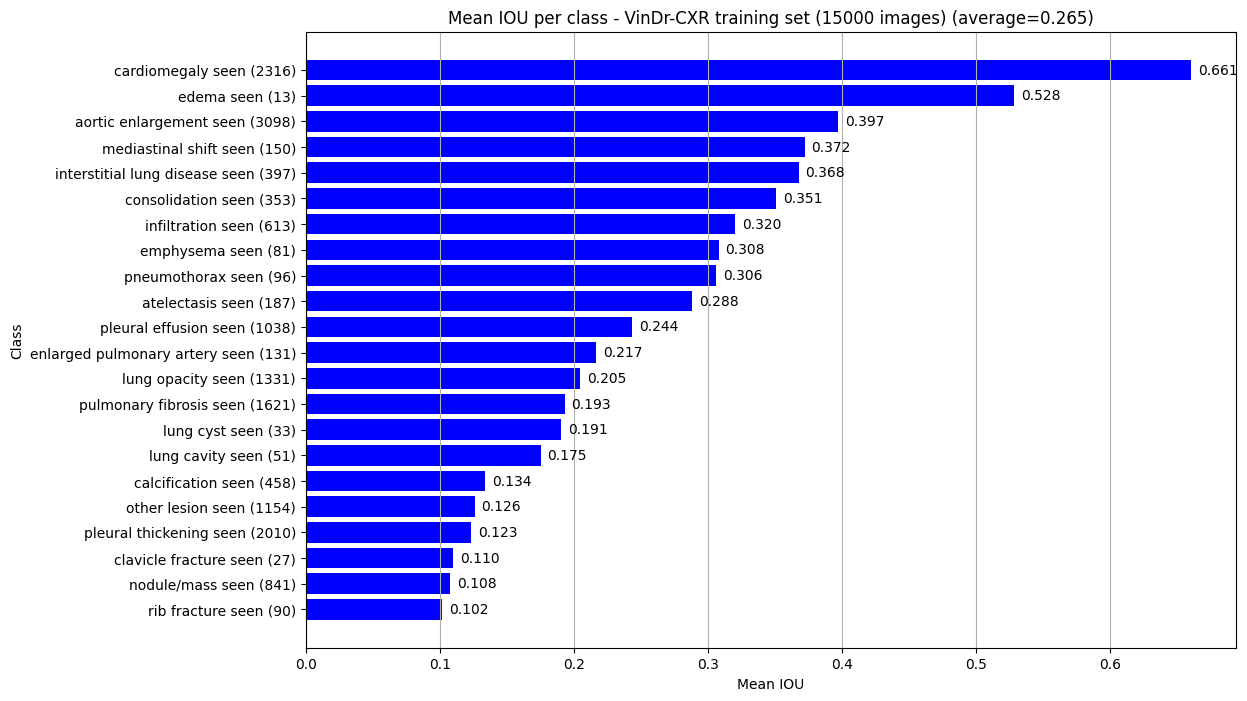

In [81]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp2['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp2['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR training set (15000 images)',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

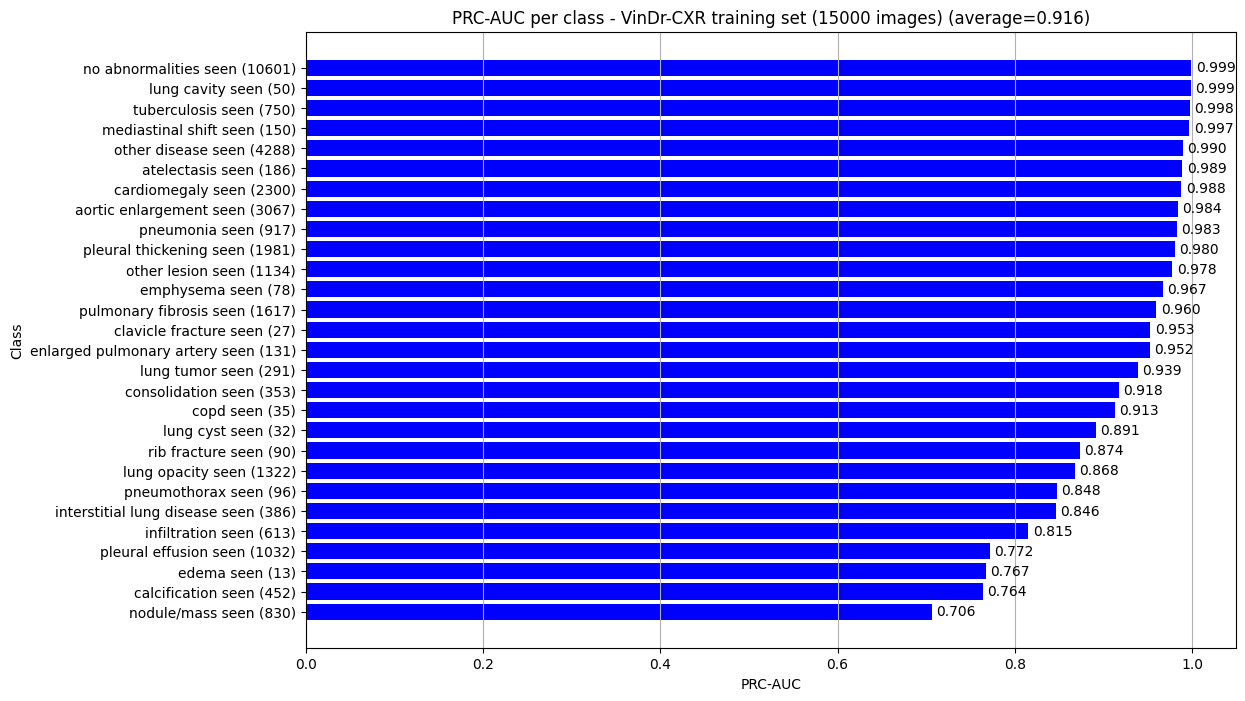

In [83]:
plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} ({label_frequencies["train"][x]})' for x in VINBIG_LABELS],
    metric_values=tmp2['prc_auc']['per_class'],
    title='PRC-AUC per class - VinDr-CXR training set (15000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [86]:
idxs = np.argsort(tmp2['ious'])[::-1]
len(idxs)

16089

In [104]:
idx = idxs[-1000]
print(tmp2['ious'][idx])
print()
print(tmp2['image_paths'][idx])
print()
print(tmp2['phrases'][idx])

0.01016150708654602

/mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/afb41a2217d37b54f0427fc1c69336be.jpg

pulmonary fibrosis seen


image_path: /mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images/afb41a2217d37b54f0427fc1c69336be.jpg
0: Consolidation
[[702.4110107421901, 1225.1600341797, 1186.9799804688, 1614.6899414062]]
1: Infiltration
[[645.81799316406, 1281.3299560547, 1115.6899414062, 1657.7900390625], [670.5830078125, 1128.7399902344, 1167.3100585938, 1650.1600341797]]
2: Lung Opacity
[[670.5830078125, 1128.7399902344, 1167.3100585938, 1650.1600341797]]
3: Pleural thickening
[[904.57000732422, 345.76998901367006, 1203.4699707031, 500.55499267578006]]
4: Pulmonary fibrosis
[[781.3980102539099, 814.30200195312, 852.4520263671901, 880.28100585938]]


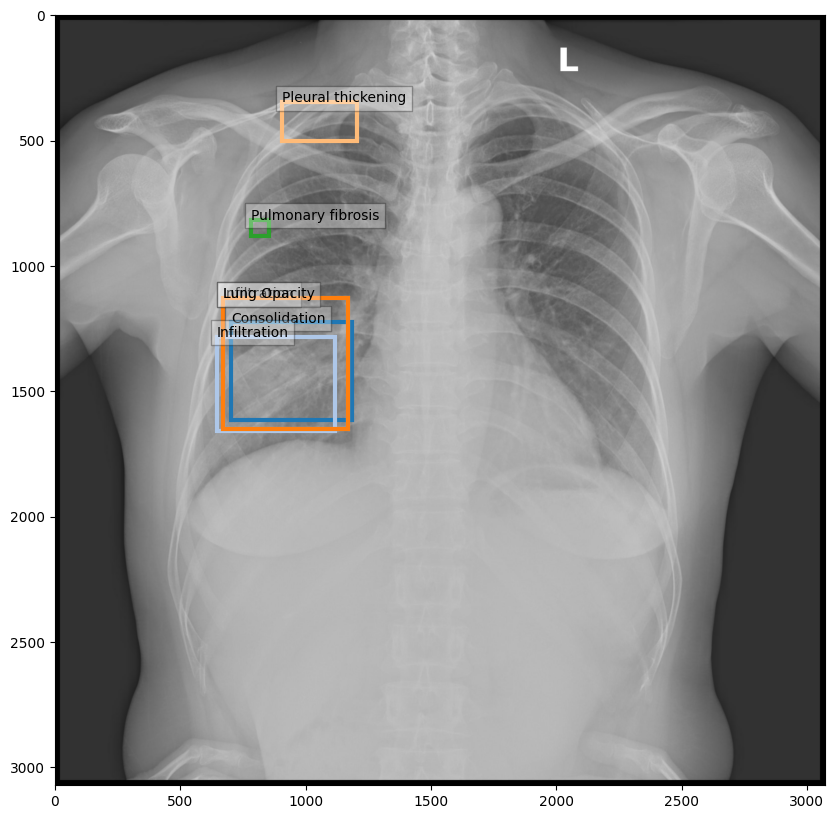

In [105]:
key = os.path.basename(tmp2['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, train_image_id_2_bboxes[key], verbose=True)

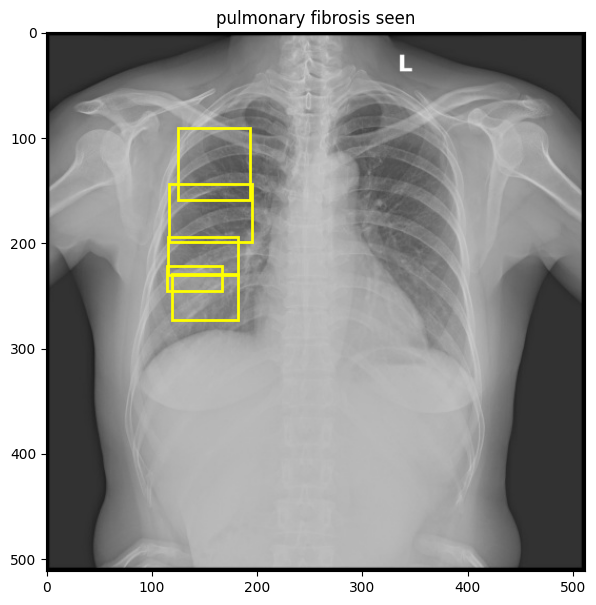

In [106]:
from medvqa.evaluation.plots import visualize_visual_grounding_as_bboxes
visualize_visual_grounding_as_bboxes(
    image_path=tmp2['image_paths'][idx],
    phrases=[tmp2['phrases'][idx]],
    bboxes=[tmp2['pred_bboxes'][idx]] if tmp2['pred_bboxes'][idx] is not None else [[]],
    figsize=(7, 7),
    max_cols=1,
)

# 5) Phrase Grounding: DN121+CXRFE+FiLM+bbox; Chest ImaGenome + VinDR-CXR

In [107]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance o

# 6) Phrase Grounding: DN121+CXRFE+FiLM+bbox; Chest ImaGenome + VinDR-CXR + MIMIC-CXR (facts + GPT-4 labels)

In [108]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
---------------------